In [4]:
%tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
1.15.0


In [5]:
pip install keras==2.2.4 # 需要安裝 keras 2.2.4 的版本

     |████████████████████████████████| 317kB 5.0MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [6]:
from google.colab import drive 
drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# 下載基於 keras 的 yolov3 程式碼
%cd 'gdrive/My Drive/D49-50_final'
# !git clone https://github.com/qqwweee/keras-yolo3 # 如果之前已經下載過就可以註解掉
# %cd keras-yolo3

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/D49-50_final


In [7]:
import os
if not os.path.exists("model_data/yolo.h5"):
  # 下載 yolov3 的網路權重，並且把權重轉換為 keras 能夠讀取的格式
  print("Model doesn't exist, downloading...")
  os.system("wget https://pjreddie.com/media/files/yolov3.weights")
  print("Converting yolov3.weights to yolo.h5...")
  os.system("python convert.py yolov3.cfg yolov3.weights model_data/yolo.h5")
else:
  print("Model exist")

Model exist


In [8]:
# 將資料集格式轉為yolo3的格式
if not os.path.exists("train.txt"):
    all_labels = open('data/labels/labels.csv', 'r')
    line = all_labels.readline()
    print(line[:-1].split(','))

    list_file = open('train.txt', 'w')
    file_name = ''
    file_animal = ''

    while line:
        line = all_labels.readline()
        if line == '':
            break
        line_messages = line[:-1].split(',')
        print(line_messages)
        if file_name == line_messages[0]:
            list_file.write(' ' + line_messages[4] + ',' + line_messages[5] + ',' + line_messages[6] + ',' + line_messages[7] + ',' + file_animal)
        else:
            if file_name != '':
                list_file.write('\n')
            file_name = line_messages[0]
            if line_messages[3] == 'kangaroo':
                file_animal = '0'
                list_file.write('data/images/' + file_name + ' ' + line_messages[4] + ',' + line_messages[5] + ',' + line_messages[6] + ',' + line_messages[7] + ',0')
            else:
                file_animal = '1'
                list_file.write('data/images/' + file_name + ' ' + line_messages[4] + ',' + line_messages[5] + ',' + line_messages[6] + ',' + line_messages[7] + ',1')
    list_file.close()
else:
    print("train.txt exist")

train.txt exist


In [9]:
# 將 train.py 所需要的套件載入
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

Using TensorFlow backend.


In [0]:
from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper

In [11]:
if not os.path.exists("model_data/yolo_weights.h5"):
  print("Converting pretrained YOLOv3 weights for training")
  os.system("python convert.py -w yolov3.cfg yolov3.weights model_data/yolo_weights.h5") 
else:
  print("Pretrained weights exists")

Pretrained weights exists


In [0]:
from PIL import ImageFile 
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [13]:
# 如果train完，之後要再打開此檔案，建議將此段註解! 省去重新train的時間(除非有改模型)
annotation_path = 'train.txt' # 轉換好格式的標註檔案
log_dir = 'logs/000/' # 訓練好的模型儲存的路徑
classes_path = 'model_data/classes.txt'
anchors_path = 'model_data/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

input_shape = (416,416) # multiple of 32, hw

is_tiny_version = len(anchors)==6 # default setting
if is_tiny_version:
    model = create_tiny_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/tiny_yolo_weights.h5')
else:
    model = create_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/yolo_weights.h5') # make sure you know what you freeze

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# 分為 training 以及 validation
val_split = 0.1
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

# Train with frozen layers first, to get a stable loss.
# Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
# 一開始先 freeze YOLO 除了 output layer 以外的 darknet53 backbone 來 train
if True:
    model.compile(optimizer=Adam(lr=1e-3), loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})

    batch_size = 16
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    # 模型利用 generator 產生的資料做訓練，強烈建議大家去閱讀及理解 data_generator_wrapper 在 train.py 中的實現
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=50,
            initial_epoch=0,
            callbacks=[logging, checkpoint])
    model.save_weights(log_dir + 'trained_weights_stage_1.h5')

# Unfreeze and continue training, to fine-tune.
# Train longer if the result is not good.
if True:
    # 把所有 layer 都改為 trainable
    for i in range(len(model.layers)):
        model.layers[i].trainable = True
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
    print('Unfreeze all of the layers.')

    batch_size = 16 # note that more GPU memory is required after unfreezing the body
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=100,
        initial_epoch=50,
        callbacks=[logging, checkpoint, reduce_lr, early_stopping])
    model.save_weights(log_dir + 'trained_weights_final.h5')














Create YOLOv3 model with 9 anchors and 2 classes.


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((1, 1, 1024, 21) vs (255, 1024, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((1, 1, 512, 21) vs (255, 512, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_75 due to mismatch in shape ((1,

Load weights model_data/yolo_weights.h5.
Freeze the first 249 layers of total 252 layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 328 samples, val on 36 samples, with batch size 16.




Epoch 1/50
20/20 [==============================] - 127s 6s/step - loss: 5881.9626 - val_loss: 1589.3342

Epoch 2/50
20/20 [==============================] - 24s 1s/step - loss: 923.1684 - val_loss: 405.9463
Epoch 3/50
20/20 [==============================] - 24s 1s/step - loss: 361.2529 - val_loss: 238.8708
Epoch 4/50
20/20 [==============================] - 12s 599ms/step - loss: 245.0884 - val_loss: 183.9740
Epoch 5/50
20/20 [==============================] - 24s 1s/step - loss: 184.1282 - val_loss: 139.2542
Epoch 6/50
20/20 [==============================] - 24s 1s/step - loss: 146.7554 - val_loss: 118.7541
Epoch 7/50
20/20 [==============================] - 24s 1s/step - loss: 124.1177 - val_loss: 101.8913
Epoch 8/50
20/20 [==========

In [0]:
from PIL import Image
image = Image.open('data/images/raccoon-75.jpg') 

In [0]:
annotation_path = 'train.txt' # 轉換好格式的標註檔案
log_dir = 'logs/000/' # 訓練好的模型儲存的路徑
classes_path = 'model_data/classes.txt'
anchors_path = 'model_data/yolo_anchors.txt'

In [16]:
from yolo import YOLO
yolo_model = YOLO(model_path=log_dir + 'trained_weights_stage_1.h5', classes_path=classes_path)
r_image = yolo_model.detect_image(image)

logs/000/trained_weights_stage_1.h5 model, anchors, and classes loaded.
(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (29, 23) (615, 440)
2.436826244000258


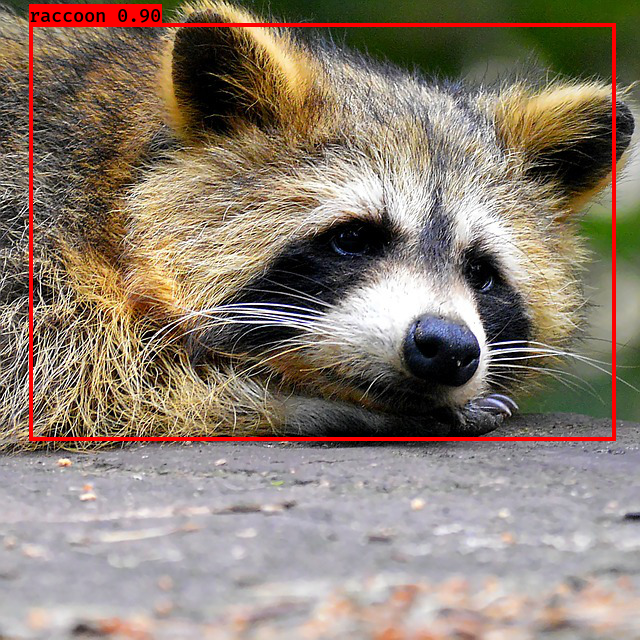

In [17]:
r_image

In [0]:
# other pic
from PIL import Image
image = Image.open('data/images/00088.jpg') 

In [19]:
from yolo import YOLO
yolo_model = YOLO(model_path=log_dir + 'trained_weights_stage_1.h5', classes_path=classes_path)
r_image = yolo_model.detect_image(image)

logs/000/trained_weights_stage_1.h5 model, anchors, and classes loaded.
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.70 (311, 153) (417, 315)
2.420579433000057


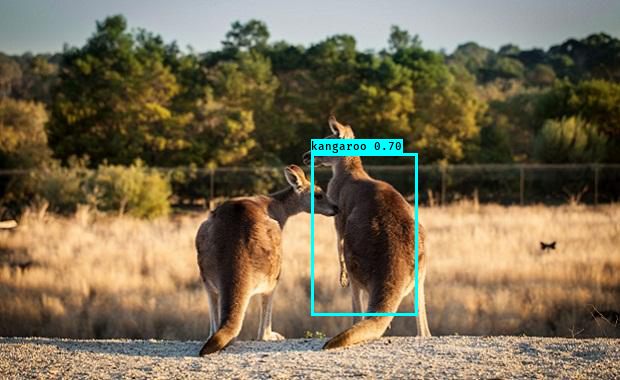

In [20]:
r_image

In [0]:
from yolo import YOLO,detect_video

In [0]:
annotation_path = 'train.txt' # 轉換好格式的標註檔案
log_dir = 'logs/000/' # 訓練好的模型儲存的路徑
classes_path = 'model_data/classes.txt'
anchors_path = 'model_data/yolo_anchors.txt'
# MODEL=log_dir + 'trained_weights_stage_1.h5'
# video_input='videos/Kangaroo.mp4'
# video_output='videos/Kangaroo-YOLO.mp4'

In [23]:
yolo_model = YOLO(model_path=log_dir + 'trained_weights_stage_1.h5', classes_path=classes_path)

logs/000/trained_weights_stage_1.h5 model, anchors, and classes loaded.


In [0]:
# detect_video(yolo_model,video_path=video_input,output_path=video_output)

In [26]:
import cv2
import numpy as np
from PIL import Image
import timeit

starttime = timeit.default_timer()
video = cv2.VideoCapture('videos/Kangaroo.mp4')

# 使用 XVID 編碼
fourcc = cv2.VideoWriter_fourcc(*'XVID')

# 建立 VideoWriter 物件，輸出影片至 output.avi
# FPS 為 30.0，解析度為 1280*720
output = cv2.VideoWriter('Kangaroo-object-detection.avi', fourcc, 30.0, (1280, 720))

k = 0
while(video.isOpened()):
    ret, frame = video.read()
    if ret == True:
        # 寫入影格
        image = Image.fromarray(frame)
        image = np.array(yolo_model.detect_image(image))
        output.write(image)
        k += 1
    else:
        break
    
# 釋放所有資源
video.release()
output.release()

print('共耗時:',round((timeit.default_timer() - starttime), 2), '秒，FPS:', round(k/(timeit.default_timer() - starttime), 2))

Streaming output truncated to the last 5000 lines.
(416, 416, 3)
Found 0 boxes for img
0.05010819300014191
(416, 416, 3)
Found 0 boxes for img
0.048439826000048924
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.38 (407, 468) (735, 616)
0.04931381699998383
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.38 (407, 468) (735, 616)
0.050534007000351266
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.42 (448, 468) (700, 623)
0.04850539600010961
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.31 (497, 434) (727, 648)
kangaroo 0.35 (902, 435) (1280, 699)
0.0518834180002159
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.37 (869, 440) (1280, 700)
0.04745734300013282
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.35 (876, 444) (1280, 689)
0.05057623699985925
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.35 (876, 444) (1280, 689)
0.049688641999637184
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.32 (500, 438) (730, 646)
kangaroo 0.40 (883, 437) (1280, 690)
0.053460989000086556
(416, 416, 3)
Found 2

In [27]:
starttime = timeit.default_timer()
video = cv2.VideoCapture('videos/Raccoon.mp4')

# 使用 XVID 編碼
fourcc = cv2.VideoWriter_fourcc(*'XVID')

# 建立 VideoWriter 物件，輸出影片至 output.avi
# FPS 值為 30.0，解析度為 1280*720
output = cv2.VideoWriter('Raccoon-object-detection.avi', fourcc, 30.0, (1280, 720))

k = 0
while(video.isOpened()):
    ret, frame = video.read()
    if ret == True:
        # 寫入影格
        image = Image.fromarray(frame)
        image = np.array(yolo_model.detect_image(image))
        output.write(image)
        k += 1
    else:
        break
    
# 釋放所有資源
video.release()
output.release()

print('共耗時:',round((timeit.default_timer() - starttime), 2), '秒，FPS:', round(k/(timeit.default_timer() - starttime), 2))

Streaming output truncated to the last 5000 lines.
Found 1 boxes for img
raccoon 0.31 (187, 0) (1090, 720)
0.05392831400013165
(416, 416, 3)
Found 0 boxes for img
0.0439420349998727
(416, 416, 3)
Found 1 boxes for img
raccoon 0.34 (163, 0) (1113, 720)
0.049078689999987546
(416, 416, 3)
Found 1 boxes for img
raccoon 0.33 (190, 0) (1090, 720)
0.04956205000007685
(416, 416, 3)
Found 0 boxes for img
0.04818217899992305
(416, 416, 3)
Found 0 boxes for img
0.04746377199990093
(416, 416, 3)
Found 0 boxes for img
0.04586848999997528
(416, 416, 3)
Found 0 boxes for img
0.04495199699977093
(416, 416, 3)
Found 0 boxes for img
0.04515627199998562
(416, 416, 3)
Found 0 boxes for img
0.04572918700023365
(416, 416, 3)
Found 0 boxes for img
0.044471867000083876
(416, 416, 3)
Found 0 boxes for img
0.044839373999820964
(416, 416, 3)
Found 0 boxes for img
0.0444529380001768
(416, 416, 3)
Found 0 boxes for img
0.04894691800018336
(416, 416, 3)
Found 0 boxes for img
0.046048958000028506
(416, 416, 3)
Found